### Import all needed package

In [1]:
import os
import ast
import numpy as np
import pandas as pd
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
import context

build = context.build_promoter
construct = context.construct_neural_net
encode = context.encode_sequences
organize = context.organize_data

ROOT_DIR = os.getcwd()[:os.getcwd().rfind('Express')] + 'ExpressYeaself/'
SAVE_DIR = ROOT_DIR + 'expressyeaself/models/lstm/saved_models/'
ROOT_DIR

Using TensorFlow backend.


'C:\\Users\\Lisboa\\011019\\ExpressYeaself/'

### Define the input data

#### Using the full data set

In [2]:
sample_filename = ('10000_from_20190612130111781831_percentiles_els_binarized_homogeneous_deflanked_'
                   'sequences_with_exp_levels.txt.gz')

#### Define the absolute path

In [3]:
sample_path = ROOT_DIR + 'example/processed_data/' + sample_filename

### Encode sequences

In [4]:
# Seems to give slightly better accuracy when expression level values aren't scaled.
scale_els = False

In [5]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=scale_els)
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)

### Bulid the 3 dimensions LSTM model

#### Reshape encoded sequences

In [107]:
X_padded = X_padded.reshape(-1)
X_padded = X_padded.reshape(int(num_seqs), 1, 5 * int(max_sequence_len))

#### Reshape expression levels

In [108]:
y_scaled = y_scaled.reshape(len(y_scaled), 1, 1)

#### Perform a train-test split

In [109]:
test_size = 0.25

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=test_size)

#### Build the model

In [111]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
epochs = 50
dropout = 0.3
learning_rate = 0.01

# Define the checkpointer to allow saving of models
model_type = 'lstm_sequential_3d_onehot'
save_path = SAVE_DIR + model_type + '.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=save_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the model
model = Sequential()

# Build up the layers

model.add(Dense(1024, kernel_initializer='uniform', input_shape=(1,5*int(max_sequence_len),)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
# model.add(Dense(512, kernel_initializer='uniform', input_shape=(1,1024,)))
# model.add(Activation('softmax'))
# model.add(Dropout(dropout))
model.add(Dense(256, kernel_initializer='uniform', input_shape=(1,512,)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
# model.add(Dense(128, kernel_initializer='uniform', input_shape=(1,256,)))
# model.add(Activation('softmax'))
# model.add(Dropout(dropout))
# model.add(Dense(64, kernel_initializer='uniform', input_shape=(1,128,)))
# model.add(Activation('softmax'))
# model.add(Dropout(dropout))
# model.add(Dense(32, kernel_initializer='uniform', input_shape=(1,64,)))
# model.add(Activation('softmax'))
# model.add(Dropout(dropout))
# model.add(Dense(16, kernel_initializer='uniform', input_shape=(1,32,)))
# model.add(Activation('softmax'))
# model.add(Dropout(dropout))
# model.add(Dense(8, kernel_initializer='uniform', input_shape=(1,16,)))
# model.add(Activation('softmax'))
model.add(LSTM(units=1, return_sequences=True))
sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())



# model.add(LSTM(100,input_shape=(int(max_sequence_len), 5)))
# model.add(Dropout(dropout))
# model.add(Dense(50, activation='sigmoid'))
# # model.add(Dense(25, activation='sigmoid'))
# # model.add(Dense(12, activation='sigmoid'))
# # model.add(Dense(6, activation='sigmoid'))
# # model.add(Dense(3, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='mse',
#               optimizer='rmsprop',
#               metrics=['accuracy'])
# print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 1, 1024)           410624    
_________________________________________________________________
activation_69 (Activation)   (None, 1, 1024)           0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 1, 1024)           0         
_________________________________________________________________
dense_88 (Dense)             (None, 1, 256)            262400    
_________________________________________________________________
activation_70 (Activation)   (None, 1, 256)            0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 1, 1)              1032      
Total para

### Fit and Evaluate the model

Train on 7500 samples, validate on 2500 samples
Epoch 1/500
7500/7500 [==============================] - 4s 594us/step - loss: 0.4805 - acc: 0.4929 - val_loss: 0.4735 - val_acc: 0.4740

Epoch 00001: val_acc improved from -inf to 0.47400, saving model to C:\Users\Lisboa\011019\ExpressYeaself/expressyeaself/models/lstm/saved_models/lstm_sequential_3d_onehot.hdf5
Epoch 2/500
7500/7500 [==============================] - 2s 252us/step - loss: 0.4334 - acc: 0.4929 - val_loss: 0.4249 - val_acc: 0.4740

Epoch 00002: val_acc did not improve from 0.47400
Epoch 3/500
7500/7500 [==============================] - 2s 283us/step - loss: 0.3886 - acc: 0.4929 - val_loss: 0.3805 - val_acc: 0.4740

Epoch 00003: val_acc did not improve from 0.47400
Epoch 4/500
7500/7500 [==============================] - 2s 263us/step - loss: 0.3497 - acc: 0.4929 - val_loss: 0.3427 - val_acc: 0.4740

Epoch 00004: val_acc did not improve from 0.47400
Epoch 5/500
7500/7500 [==============================] - 2s 291us/step - 

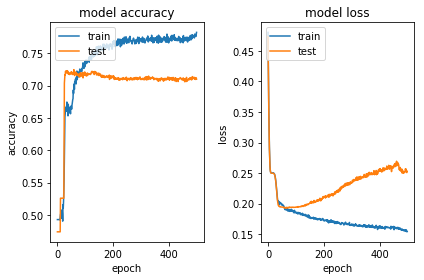

In [112]:
# Fit
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=eposhs,verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpointer])


# Evaluate
score = max(history.history['val_acc'])
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()

### Bulid the 2 dimensions LSTM model

As for the data we have, we only have 1 output and that means we only have 1 time step, if we can delete that dimension in that model, then we can have a 2 dimensions LSTM model.

#### Load the data again

In [6]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=scale_els)
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=test_size)

#### Build up the model

In [7]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
epochs = 50
dropout = 0.3
learning_rate = 0.01

# Define the checkpointer to allow saving of models
model_type = 'lstm_sequential_2d_onehot'
save_path = SAVE_DIR + model_type + '.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=save_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the model
model = Sequential()

# Build up the layers


model.add(LSTM(100,input_shape=(int(max_sequence_len), 5)))
model.add(Dropout(dropout))
model.add(Dense(50, activation='sigmoid'))
# model.add(Dense(25, activation='sigmoid'))
# model.add(Dense(12, activation='sigmoid'))
# model.add(Dense(6, activation='sigmoid'))
# model.add(Dense(3, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 47,501
Trainable params: 47,501
Non-trainable params: 0
_________________________________________________________________
None


### Fit and Evaluate the model

Instructions for updating:
Use tf.cast instead.
Train on 7500 samples, validate on 2500 samples
Epoch 1/500
7500/7500 [==============================] - 6s 855us/step - loss: 0.2107 - acc: 0.6719 - val_loss: 0.1957 - val_acc: 0.7008

Epoch 00001: val_acc improved from -inf to 0.70080, saving model to C:\Users\Lisboa\011019\ExpressYeaself/expressyeaself/models/lstm/saved_models/lstm_sequential_2d_onehot.hdf5
Epoch 2/500
7500/7500 [==============================] - 6s 755us/step - loss: 0.1912 - acc: 0.7187 - val_loss: 0.1911 - val_acc: 0.7304

Epoch 00002: val_acc improved from 0.70080 to 0.73040, saving model to C:\Users\Lisboa\011019\ExpressYeaself/expressyeaself/models/lstm/saved_models/lstm_sequential_2d_onehot.hdf5
Epoch 3/500
7500/7500 [==============================] - 6s 735us/step - loss: 0.1859 - acc: 0.7241 - val_loss: 0.1872 - val_acc: 0.7116

Epoch 00003: val_acc did not improve from 0.73040
Epoch 4/500
7500/7500 [==============================] - 5s 730us/step - loss: 0.18

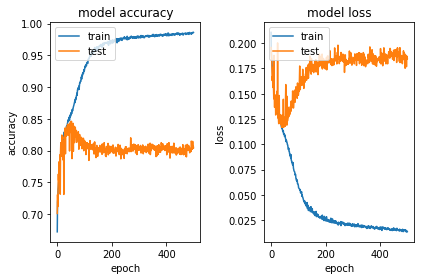

In [8]:
# Fit
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpointer])


# Evaluate
score = max(history.history['val_acc'])
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()

## Checking predictions on a small sample of native data

In [10]:
input_seqs = ROOT_DIR + 'expressyeaself/models/lstm/native_sample.txt'
model_to_use = 'lstm_sequential_2d'

In [12]:
lstm_result = construct.get_predictions_for_input_file(input_seqs, model_to_use, sort_df=True, write_to_file=False)

In [13]:
lstm_result.to_csv('lstm_result')

In [14]:
lstm_result

,index,seq,el_prediction
0,16,AGTACTCTTGCTCCCACACGCTCGCGCCTGGTACGTCTAAGGACGG...,0.991525
1,20,AGTAGCGGCGAAAGAGTCGTGGGTGCGCAGGTCTGCTCGCTTGGGG...,0.987464
2,95,AGTGGAATTGTACGGGGCACATCTTAGGCAGGGGTGGATGCGGCTT...,0.985924
3,33,AGTATGTCGTCGCGTGTTGTTTCTAATCTTCGTGGCCTGTGGTGCA...,0.985015
4,58,AGTCGCTCGGAACGTTACAGTTCCGGGGTACAAGACGGGTTATTCT...,0.983350
5,87,AGTGCGGGGGTCTAGGTCTCAGGTTAACTAGTGGATGCGGATGCTG...,0.983287
6,24,AACATCACAATTTTGTCATGTTATTCGCAGGAATCATTCCGCGCAT...,0.977954
7,88,AGTGCGTCTAGTCGTTGTCGCGTGGTGGACGTGGGACCTCGGTAGG...,0.976118
8,46,AACATGTTTCATGCCTACGTCGTCTTTACATTTAAATTCTATTTGG...,0.973765
9,40,AGTCACTGGCCATTAGCGACGAAGTCTGTTGTCGTGGGTGCGAAGC...,0.966606
